In [1]:
!pip install evaluate
!pip install datasets

### Data/Model setup

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')

# sequences = ['He will absolutely buy this book','He is still unsure']

# batch = tokenizer(sequences,truncation=True,padding=True,return_tensors='pt')

# batch['labels'] = torch.tensor([1,0])

# optimizer = AdamW(model.parameters(),no_deprecation_warning=True)
# loss = model(**batch).loss
# loss.backward()
# optimizer.step()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from datasets import load_dataset


data = load_dataset('glue','mrpc')
data

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [5]:
data['test'][0]

{'sentence1': "PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .",
 'sentence2': 'Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .',
 'label': 1,
 'idx': 0}

In [6]:
data['validation'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [7]:
def preprocessor(sample):
  return tokenizer(
      sample['sentence1'],sample['sentence2'],truncation=True
  )


data2 = data.map(preprocessor,batched=True)
data2 = data2.remove_columns(['sentence1', 'sentence2', 'idx'])
data2 = data2.rename_column('label','labels')
data2 = data2.with_format('torch')
data2['train'][0]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'labels': tensor(1),
 'input_ids': tensor([  101,  7277,  2180,  5303,  4806,  1117,  1711,   117,  2292,  1119,
          1270,   107,  1103,  7737,   107,   117,  1104,  9938,  4267, 12223,
         21811,  1117,  2554,   119,   102, 11336,  6732,  3384,  1106,  1140,
          1112,  1178,   107,  1103,  7737,   107,   117,  7277,  2180,  5303,
          4806,  1117,  1711,  1104,  9938,  4267, 12223, 21811,  1117,  2554,
           119,   102]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1])}

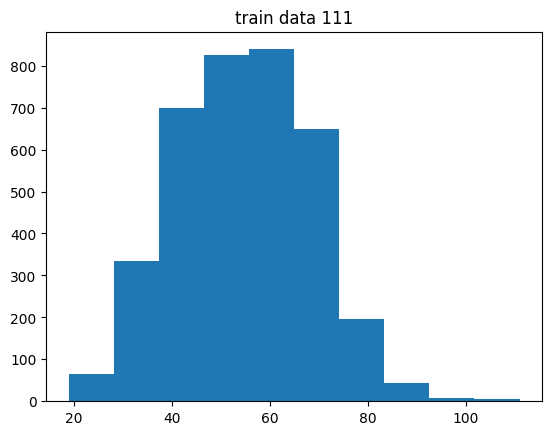

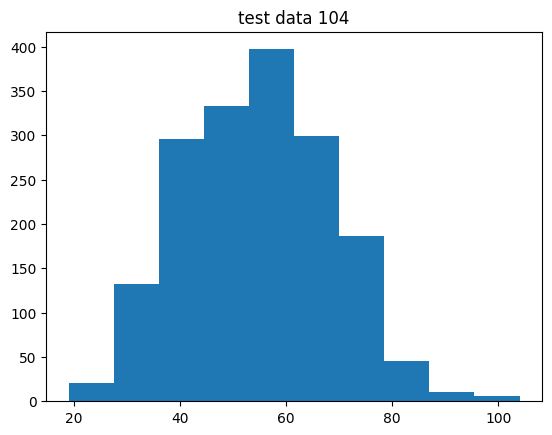

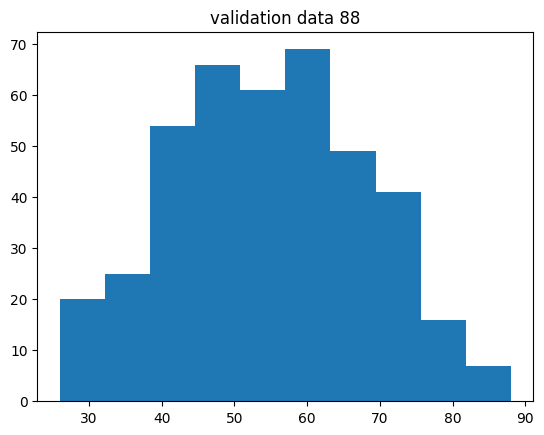

In [8]:
import matplotlib.pyplot as plt

# Num of tokens in each Data Split

def plot_token_lenghts(data,title):

  tokens_lenght = [len(tokenizer(sample['sentence1'],sample['sentence2'])['input_ids']) for sample in data]
  plt.hist(tokens_lenght)
  plt.title(f'{title} {max(tokens_lenght)}')
  plt.show()
  return None

plot_token_lenghts(data['train'],'train data')
plot_token_lenghts(data['test'],'test data')
plot_token_lenghts(data['validation'],'validation data')


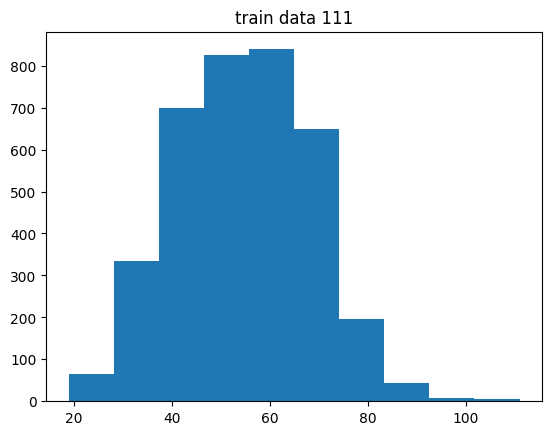

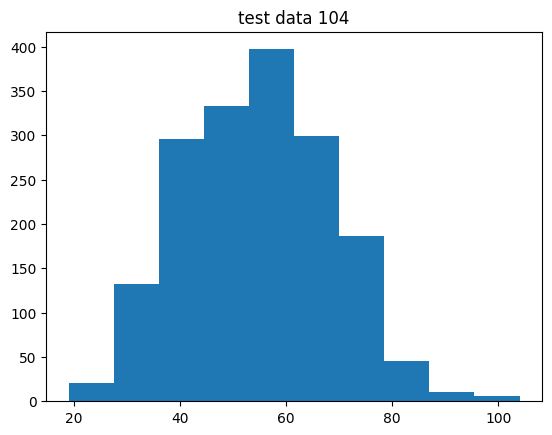

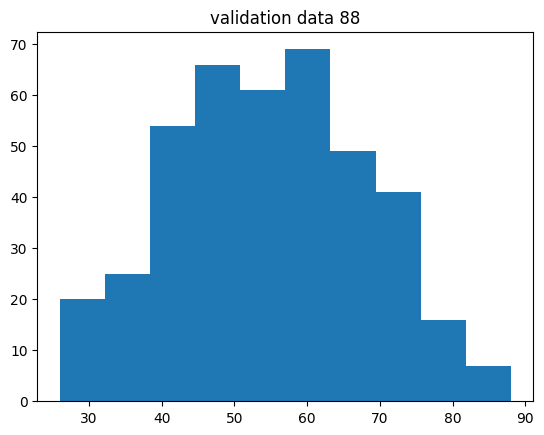

In [9]:
# Num of tokens in each Data Split after Padding

def plot_token_lenghts_2(data,title):

  tokens_lenght = [len(sample['input_ids']) for sample in data]
  plt.hist(tokens_lenght)
  plt.title(f'{title} {max(tokens_lenght)}')
  plt.show()
  return None

plot_token_lenghts_2(data2['train'],'train data')
plot_token_lenghts_2(data2['test'],'test data')
plot_token_lenghts_2(data2['validation'],'validation data')

In [50]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_colate = DataCollatorWithPadding(tokenizer)

train_dataloader = DataLoader(data2['train'],batch_size=16,shuffle=True,collate_fn=data_colate)

test_dataloader = DataLoader(data2['test'],batch_size=16,collate_fn=data_colate)


In [11]:
sample = next(iter(train_dataloader))

In [29]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

In [38]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']


  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing chess','okay what ever he is a good chess player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]


for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 64}
{'equivalent': 99}
{'equivalent': 0}


### Trainer Object

In [13]:
from transformers import DataCollatorWithPadding, Trainer,TrainingArguments
import numpy as np
import evaluate


input_data = data.map(preprocessor,batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments('test-trainer',
                                  evaluation_strategy='epoch',
                                  num_train_epochs = 5,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16)


def compute_metrics(eval_preds):
  logist, labels = eval_preds
  metric = evaluate.load("glue","mrpc")
  predictions = np.argmax(logist,axis=-1)
  return metric.compute(predictions=predictions,references = labels)


trainer = Trainer(
    model,
    training_args,
    data_collator = data_collator,
    train_dataset = input_data['train'],
    eval_dataset = input_data['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
predictions = trainer.predict(input_data['validation'])
preds = np.argmax(predictions.predictions,axis=-1)
metric = evaluate.load("glue","mrpc")
metric.compute(predictions = preds, references = predictions.label_ids)


{'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.491955,0.774493,0.851470
2,No log,0.448886,0.825507,0.876487
3,0.410700,0.679673,0.816812,0.864957
4,0.410700,0.807103,0.830725,0.877926
5,0.077100,0.822263,0.831304,0.877474


TrainOutput(global_step=1150, training_loss=0.21617277394170348, metrics={'train_runtime': 335.4731, 'train_samples_per_second': 54.669, 'train_steps_per_second': 3.428, 'total_flos': 742152009410640.0, 'train_loss': 0.21617277394170348, 'epoch': 5.0})

In [40]:
sentences = [['He is good at playing chess','okay what ever he is a good chess player'],
             ['Look at the bird',"don't look at the bird"]]


for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 64}
{'equivalent': 99}


In [48]:
result = trainer.predict(input_data['validation'])

In [49]:
result.metrics

{'test_loss': 0.738714337348938,
 'test_accuracy': 0.8529411764705882,
 'test_f1': 0.8958333333333334,
 'test_runtime': 2.5947,
 'test_samples_per_second': 157.242,
 'test_steps_per_second': 10.02}

### Manual training loop

In [153]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AdamW
from datasets import load_dataset
from torch.utils.data.dataloader import DataLoader
import torch

checkpoint = 'bert-base-cased'

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data = load_dataset('glue','mrpc')


device = torch.device('cuda' if torch.cuda.is_available else 'gpu')

def preprocessor(sample):
  return tokenizer(
      sample['sentence1'],sample['sentence2'],truncation=True )




data_ = data.map(preprocessor, batched=True)

data_ = data_.remove_columns(['sentence1','sentence2','idx'])
data_ = data_.rename_column('label','labels')
data_.set_format('torch')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [154]:
data_

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [155]:
data_['test'][0]['input_ids']

tensor([  101,  7054,  1658,  2924,   112,   188,  2705,  3389,  2575,   117,
         2639, 25991,   117,  1105,  3230,  6492,   117,  1103,  2705,  2798,
         2575,   117,  1209,  2592,  2626,  1106,  1828,  1573,   119,   102,
         9493,  2534, 20961,  4124,  2639, 25991,  1105,  1990,  2534,  7748,
         4124,  3230,  6492,  1209,  2592,  1106,  1573,   119,   102])

In [156]:
train_dataloader = DataLoader(data_['train'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True)

test_dataloader = DataLoader(data_['test'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

val_dataloader = DataLoader(data_['validation'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

In [157]:
sample = next(iter(train_dataloader))
sample

{'labels': tensor([1, 0, 1, 1, 1]), 'input_ids': tensor([[  101,  1994,  1110, 16970,  1104,  6083,   117,  1549,  1157, 19716,
          1107,  6469,  1105,  5008,   119,   102,  1109,  1244,  1311,  1110,
         16970,  1104,  1996,  6083,  1107, 19427,  1549, 19716,  1107,  6469,
          1105,  5008,   119,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1252,  1119,  1110,  1103,  1178,  3234,  1150,  1144,  1281,
          1569,  5530, 22843,  1116,  1177,  1677,   117,  8184,  1146,  1117,
          5573,  3779,  1113,  9667,  1165,  1103,  1244,  8180,  5361,  1468,
          1104,  1738, 11889,  1140,   119,   102,  1252,  1119,  1110,  1103,
          1178,  3234,  1150,  1144, 

In [158]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd


In [190]:
def train_loop(model,data_loader):
  optimizer = AdamW(model.parameters(),lr=5e-5,no_deprecation_warning=True)
  model = model.to(device)
  model.train()
  com_loss = 0
  com_acc = 0
  com_f1 = 0
  for i,batch in enumerate(data_loader):
    batch['labels'] = batch['labels'].to(device)
    batch['input_ids'] = batch['input_ids'].to(device)
    batch['token_type_ids'] = batch['token_type_ids'].to(device)
    batch['attention_mask'] = batch['attention_mask'].to(device)

    optimizer.zero_grad()
    loss,logits = model(**batch).values()
    loss.backward()
    optimizer.step()

    y_pred = logits.argmax(-1)

    com_loss += loss.item()
    com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
    com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)

  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  epoch_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }

  return epoch_result



def test_loop(model,data_loader):

  model = model.to(device)
  model.eval()
  com_loss = 0
  com_acc = 0
  com_f1 = 0

  for i,batch in enumerate(data_loader):
    batch['labels'] = batch['labels'].to(device)
    batch['input_ids'] = batch['input_ids'].to(device)
    batch['token_type_ids'] = batch['token_type_ids'].to(device)
    batch['attention_mask'] = batch['attention_mask'].to(device)
    with torch.inference_mode():
      loss,logits = model(**batch).values()
      y_pred = logits.argmax(-1)
      com_loss += loss.item()
      com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
      com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)


  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  test_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }
  return test_result


results = []

for epoch in range(1):
  print(train_loop(model,train_dataloader))
  results.append(test_loop(model,test_dataloader))
print(test_loop(model,val_dataloader))

{'loss': 0.29901011745706807, 'acc': 0.8825613079019073, 'f1': 0.8981683318195587}
{'loss': 0.6959936383929921, 'acc': 0.708130081300813, 'f1': 0.7563395276809906}


In [191]:
pd.DataFrame(results)

,loss,acc,f1
0,0.711678,0.72058,0.742291


In [174]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']


  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing football','okay what ever he is a professional football player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]



for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 3}
{'equivalent': 97}
{'equivalent': 12}


### Manual Training loop with scheduler

In [192]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AdamW
from datasets import load_dataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

import torch

checkpoint = 'bert-base-cased'

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data = load_dataset('glue','mrpc')


device = torch.device('cuda' if torch.cuda.is_available else 'gpu')

def preprocessor(sample):
  return tokenizer(
      sample['sentence1'],sample['sentence2'],truncation=True )




data_ = data.map(preprocessor, batched=True)

data_ = data_.remove_columns(['sentence1','sentence2','idx'])
data_ = data_.rename_column('label','labels')
data_.set_format('torch')

train_dataloader = DataLoader(data_['train'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True)

test_dataloader = DataLoader(data_['test'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

val_dataloader = DataLoader(data_['validation'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [195]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']

  model.to(device)
  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing football','okay what ever he is a professional football player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]



for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 33}
{'equivalent': 31}
{'equivalent': 75}


In [196]:
from transformers import get_scheduler


def train_loop(model,data_loader):
  optimizer = AdamW(model.parameters(),lr=5e-5,no_deprecation_warning=True)
  model = model.to(device)
  model.train()
  com_loss = 0
  com_acc = 0
  com_f1 = 0
  for i,batch in enumerate(data_loader):
    batch['labels'] = batch['labels'].to(device)
    batch['input_ids'] = batch['input_ids'].to(device)
    batch['token_type_ids'] = batch['token_type_ids'].to(device)
    batch['attention_mask'] = batch['attention_mask'].to(device)

    optimizer.zero_grad()
    loss,logits = model(**batch).values()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    y_pred = logits.argmax(-1)

    com_loss += loss.item()
    com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
    com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)

  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  epoch_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }

  return epoch_result



def test_loop(model,data_loader):

  model = model.to(device)
  model.eval()
  com_loss = 0
  com_acc = 0
  com_f1 = 0

  for i,batch in enumerate(data_loader):
    batch['labels'] = batch['labels'].to(device)
    batch['input_ids'] = batch['input_ids'].to(device)
    batch['token_type_ids'] = batch['token_type_ids'].to(device)
    batch['attention_mask'] = batch['attention_mask'].to(device)
    with torch.inference_mode():
      loss,logits = model(**batch).values()
      y_pred = logits.argmax(-1)
      com_loss += loss.item()
      com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
      com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)


  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  test_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }
  return test_result


results = []
epochs = 5
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps = epochs * len(train_dataloader)
)

for epoch in range(epochs):
  print(train_loop(model,train_dataloader))
  results.append(test_loop(model,test_dataloader))
print(test_loop(model,val_dataloader))

{'loss': 0.6419622543640943, 'acc': 0.6665758401453253, 'f1': 0.7626951688940812}
{'loss': 0.6482383253342124, 'acc': 0.663578564940967, 'f1': 0.7654783530124153}
{'loss': 0.6422025473834059, 'acc': 0.6674841053587685, 'f1': 0.7770414341940256}
{'loss': 0.641877912939082, 'acc': 0.669028156221621, 'f1': 0.7793542666839696}
{'loss': 0.6445700077172521, 'acc': 0.6663033605812932, 'f1': 0.7771355045197029}
{'loss': 0.632816344499588, 'acc': 0.6837398373983739, 'f1': 0.7956155632984896}


In [198]:
pd.DataFrame(results)

,loss,acc,f1
0,0.638910,0.664928,0.77787
1,0.649350,0.664928,0.77787
2,0.641356,0.664928,0.77787
3,0.653783,0.664928,0.77787
4,0.652791,0.664928,0.77787


In [204]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']

  model.to(device)
  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing football','okay what ever he is a professional football player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]



for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 74}
{'equivalent': 74}
{'equivalent': 74}


In [235]:
# evaluate batched using hugging face dataset evaluate

import evaluate

metric = evaluate.load('glue','mrpc')

for batch in test_dataloader:
  batch = {k:v.to(device) for k,v in batch.items()}
  y_pred = model(**batch).logits.argmax(-1).cpu()
  y_true = batch['labels']
  metric.add_batch(predictions = y_pred,references = y_true)

metric.compute()


{'accuracy': 0.664927536231884, 'f1': 0.7987465181058496}

### Accelerator

In [263]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AdamW
from datasets import load_dataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

import torch

checkpoint = 'bert-base-cased'

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data = load_dataset('glue','mrpc')


device = torch.device('cuda' if torch.cuda.is_available else 'gpu')

def preprocessor(sample):
  return tokenizer(
      sample['sentence1'],sample['sentence2'],truncation=True )




data_ = data.map(preprocessor, batched=True)

data_ = data_.remove_columns(['sentence1','sentence2','idx'])
data_ = data_.rename_column('label','labels')
data_.set_format('torch')

train_dataloader = DataLoader(data_['train'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True)

test_dataloader = DataLoader(data_['test'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

val_dataloader = DataLoader(data_['validation'],
                            batch_size=5,
                            collate_fn=DataCollatorWithPadding(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [264]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']

  model.to(device)
  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing football','okay what ever he is a professional football player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]



for sent in sentences:
  print(predict(model,tokenizer,sent))

{'equivalent': 58}
{'equivalent': 60}
{'equivalent': 56}


In [ ]:
from accelerate import Accelerator

def train_loop(model,data_loader):

  model = model.to(device)
  model.train()
  com_loss = 0
  com_acc = 0
  com_f1 = 0
  for i,batch in enumerate(data_loader):
    # batch['labels'] = batch['labels'].to(device)
    # batch['input_ids'] = batch['input_ids'].to(device)
    # batch['token_type_ids'] = batch['token_type_ids'].to(device)
    # batch['attention_mask'] = batch['attention_mask'].to(device)

    optimizer.zero_grad()
    loss,logits = model(**batch).values()
    # loss.backward()
    accelerator.backward(loss)
    optimizer.step()

    y_pred = logits.argmax(-1)

    com_loss += loss.item()
    com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
    com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)

  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  epoch_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }

  return epoch_result



def test_loop(model,data_loader):

  model = model.to(device)
  model.eval()
  com_loss = 0
  com_acc = 0
  com_f1 = 0

  for i,batch in enumerate(data_loader):
    batch['labels'] = batch['labels'].to(device)
    batch['input_ids'] = batch['input_ids'].to(device)
    batch['token_type_ids'] = batch['token_type_ids'].to(device)
    batch['attention_mask'] = batch['attention_mask'].to(device)
    with torch.inference_mode():
      loss,logits = model(**batch).values()
      y_pred = logits.argmax(-1)
      com_loss += loss.item()
      com_acc += accuracy_score(batch.labels.cpu(),y_pred.cpu())
      com_f1 += f1_score(batch.labels.cpu(),y_pred.cpu(),zero_division=0)


  com_loss = com_loss / len(data_loader)
  com_acc = com_acc / len(data_loader)
  com_f1 = com_f1 / len(data_loader)

  test_result = {
      'loss': com_loss,
      'acc': com_acc,
      'f1': com_f1,
  }
  return test_result


results = []
epochs = 5
accelerator = Accelerator()
optimizer = AdamW(model.parameters(),lr=5e-5,no_deprecation_warning=True)

model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader
)


for epoch in range(epochs):
  print(train_loop(model,train_dataloader))
  results.append(test_loop(model,test_dataloader))
print(test_loop(model,val_dataloader))

{'loss': 0.642660256099636, 'acc': 0.6732061762034554, 'f1': 0.7758369015181028}


In [ ]:
pd.DataFrame(results)

In [ ]:
def predict(model,tokenizer,sentences):
  model_input = tokenizer(sentences[0],sentences[1],return_tensors='pt').to(device)
  labels = ['not_equivalent','equivalent']

  model.to(device)
  prec = list(model(**model_input)[0][0].softmax(dim=0).cpu().detach().numpy()*100//1)
  result = {labels[1]:int(prec[1])}
  return result

sentences = [['He is good at playing football','okay what ever he is a professional football player'],
             ['Look at the bird',"Don't look at the bird"],
             ['Look at the bird',"We are going to visit my ante next week"]]



for sent in sentences:
  print(predict(model,tokenizer,sent))

In [ ]:
import evaluate
val_dataloader = accelerator.prepare(val_dataloader)

metric = evaluate.load('glue','mrpc')
model.eval()
for batch in val_dataloader:
  with torch.inference_mode():
    loss, logits = model(**batch).values()
    y_pred = logits.argmax(-1)
    metric.add_batch(predictions = accelerator.gather(y_pred),
                    references=accelerator.gather(batch['labels']))
metric.compute()



### Accelerator config in Distributed environment

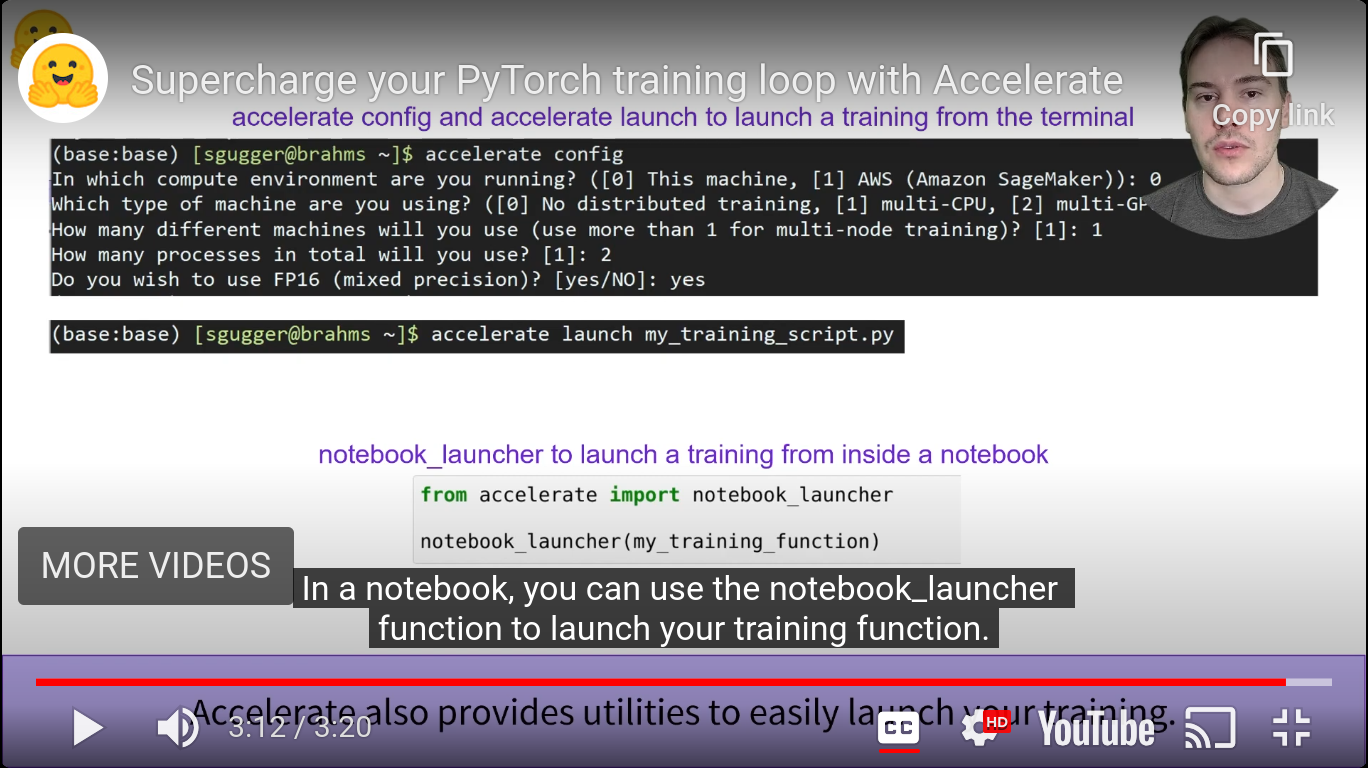

In [254]:
from datasets import load_dataset

data = load_dataset('jeffnyman/emotions',trust_remote_code=True)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [262]:
import pandas as pd

labels = pd.Series(data['train']['label'])
labels = labels.unique()
labels

array([0, 3, 2, 5, 4, 1])